[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LizbethMG-Teaching/pose2behav-book/blob/main/notebooks/analysis_single-animal.ipynb)


# 📓 Notebook 2 – Analysis of single animal (top-view mouse)
## 1. Introduction & objectives

In this notebook, we will analyze pose estimation outputs generated with SuperAnimal ModelZoo on 5-minute top-view mouse video.

**Learning goals:**

- Read, understand, and visualize pose data.
- Compute simple movement metrics.
- Interpret spatial and temporal patterns scientifically.
- Communicate results using clear, reproducible visuals.
--- 
**Instructions**

This notebook mixes pre-filled code cells (nothing to change) and coding exercises that you will complete.

👉 Here’s how to work through it:
1. Read carefully each section before running the cells.
2.	When a cell requires you to code, you’ll see a TODO comment.
3.	The TODO will tell you how many lines of code you are expected to write.
4.	Write your code only between the markers:
    
```python
# >>>>>>>>>>>>>>>>>>>
# your code goes here
# <<<<<<<<<<<<<<<<<<<
```

✋ Do not edit anything outside these markers.

⚡ After finishing the course, feel free to experiment and modify the notebook as you like!

✨ Example

What you will see in the notebook:

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
# YOUR CODE: duration = 
# YOUR CODE: print(...)
# <<<<<<<<<<<<<<<<<<< 
```

What you are expected to write: 

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
duration = frame_count / fps
print(f"Duration (s):", duration)
# <<<<<<<<<<<<<<<<<<< 
```
---
  

<img src="https://raw.githubusercontent.com/LizbethMG-Teaching/pose2behav-book/main/assets/notebook2-cover.png" width="50%">

**Narrative**

In this notebook, you will analyze pose-estimation data from a freely-moving mouse. 

You will follow **Pixel** 🐭💛, a little mouse exploring an arena.
Using pose data captured by SuperAnimal, we’ll uncover how Pixel moves, rests, and explores. 

The goal is to transform raw x,y coordinates into quantitative descriptions of movement and space use, similar to what behavioral neuroscientists do when studying exploration and locomotion.

For this exercise you will have access to the data in form of a .h5 file that has been already pre-processed as in the previous notebook. 

This is a single frame extracted of the video: 

<img src="https://raw.githubusercontent.com/LizbethMG-Teaching/pose2behav-book/main/assets/single-frame-mouse-bedding.png" width="50%">

--- 

## 2. Data Loading & Format Inspection

### 2.1 Download data (prefilled)

**📋 Instructions:**
- Run the code cell below to download a dataset file from Google Drive (with gdown), save it locally (path depends on Colab vs local), and verify the download.

In [1]:
# PREFILLED, NO NEED TO CHANGE, JUST RUN THIS CELL
# Install and import the required libraries:
!pip -q install gdown tables

import os
from pathlib import Path
import gdown, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
import re
import numpy as np
from matplotlib.collections import LineCollection


# --------------------------------------------------------------

# Detect if running in Google Colab
if "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ:
    DEST = Path("/content/cleaned_pose_downloaded.h5")
else:
    DEST = Path("cleaned_pose_downloaded.h5")  # save in current folder locally
print("Saving to:", DEST)

# Select here the experiment you want to download, comment the others:
# Opt 1: Single mouse - arena without clear floor
FILE_ID = "1H-Qf8i-Y7bN4MdUT3yHyi-yVi5Aw7Emd"
# Opt 2: Single mouse - arena with bedding
# FILE_ID = 


URL = f"https://drive.google.com/uc?id={FILE_ID}"

print("Downloading from Drive...")
_ = gdown.download(URL, str(DEST), quiet=False)

# Basic checks
assert DEST.exists() and DEST.stat().st_size > 0, "❌ Download failed or empty file."
print(f"✅ Downloaded to {DEST} ({DEST.stat().st_size/1_000_000:.2f} MB)")

# --- Load the cleaned H5 file into a pandas DataFrame ---
df = pd.read_hdf(DEST, key="df_with_missing")

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:8], "...")

Saving to: cleaned_pose_downloaded.h5


Downloading...
From: https://drive.google.com/uc?id=1H-Qf8i-Y7bN4MdUT3yHyi-yVi5Aw7Emd
To: /Users/lix/Library/CloudStorage/OneDrive-Personnel/3-work/teaching/2025_BehavioralAnalysis/pose2behav-book/notebooks/cleaned_pose_downloaded.h5
100%|██████████| 5.91M/5.91M [00:02<00:00, 2.04MB/s]


✅ Downloaded to cleaned_pose_downloaded.h5 (5.91 MB)
✅ Data loaded successfully!
Shape: (9000, 81)
Columns: ['nose_x', 'nose_y', 'nose_likelihood', 'left_ear_x', 'left_ear_y', 'left_ear_likelihood', 'right_ear_x', 'right_ear_y'] ...


---

## 3. Trajectory visualization: “Following the path”

A trajectory is the mouse’s *story on the floor*: each frame adds a dot at `(x,y)`.  
By drawing dots in order (and optionally coloring by time), we see **where** and **how** it explored.

**What you’ll do:**  
1. Pick one body part (e.g., `nose`) as the **reference point**.  
2. Plot the 2D path `(x, y)` across the arena.  
3. Color the path by **time** to see exploration progress.  
4. Mark the **start** and **end** positions.

**📋 Instructions:**
- 🧩 Complete the line marked with `# TODO`
- Choose the body part (`PART = "nose"` … or another one present in your file).  
- (Optional) Flip the Y-axis if your coordinate system has origin at top-left.  
- Try a different point (e.g., `midback`, `tail_base`) and compare paths.

**Note:** This is the list of available body-parts for this dataset:

- 'nose', 'left_ear', right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye'
- 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3'
- 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5'
- 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint', 'neck'


**Note 2: Coordinate conventions**

🎞️ In images and videos the coordinate origin (0, 0) is usually at the top-left corner of the frame:

- the x-axis increases → to the right
- the y-axis increases → downward

This is the standard in computer vision.

So, when you plot (x, y) the image appears upside-down compared to the original video.

🧭 Why flipping helps

- When you want your 2-D trajectory to match the arena as you see it on video:
- Flipping the y-axis restores the natural visual orientation.
- The mouse’s “north” (top of the screen) appears at the top of the plot again.
- If you skip that, the path will be a mirror in the vertical direction — not wrong numerically, just visually flipped.

**Questions:**  
- Does Pixel🐭 hug the walls (thigmotaxis) or visit the center?  Why do you think is that? 
- Are there parts of the arena it avoids? Why might that be (lighting, reflections)?  
- How does the time-colored path help you see **habituation** or **search patterns**?
- If you were interested in looking at exploratory motion vs. translational what body-parts would you choose to analyze? 

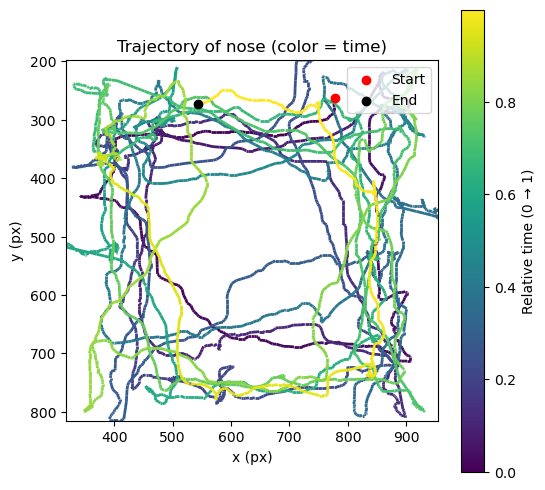

In [2]:
# === Time-colored trajectory ===

# --- Choose a bodypart to plot ---
# >>>>>>>>>>>>>>>>>>>
# TODO (1 lines): change this if you prefer another one (e.g., "nose", "mid_back", "tail_base")
PART = "nose"
# <<<<<<<<<<<<<<<<<<< 

# Extract x and y coordinates of the chosen bodypart as numeric arrays
x = df[f"{PART}_x"].to_numpy(dtype=float)
y = df[f"{PART}_y"].to_numpy(dtype=float)

# Keep only valid points (not NaN)
valid = ~np.isnan(x) & ~np.isnan(y)
xv, yv = x[valid], y[valid]

# Build the path segments between consecutive points
points = np.column_stack((xv, yv))
segments = np.stack([points[:-1], points[1:]], axis=1)

# Color by time (0 → start, 1 → end)
t = np.linspace(0, 1, len(xv))  # relative time from 0 to 1
lc = LineCollection(segments, array=t[:-1], cmap="viridis", linewidths=2) # color by time

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_collection(lc)

# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): mark start with a 'red' dot and 'end' wiht a black point 
# HINT: use ax.scatter() with arguments (x, y, color=..., label=..., zorder=3 ensures the points are on top of the line)
# ax.scatter( ... )  # start
# ax.scatter( ... )  # end
ax.scatter(xv[0], yv[0], color="red", label="Start", zorder=3)
ax.scatter(xv[-1], yv[-1], color="black", label="End", zorder=3)
# <<<<<<<<<<<<<<<<<<< 

# Set limits and appearance
ax.set_xlim(xv.min(), xv.max())
ax.set_ylim(yv.min(), yv.max())
ax.set_aspect("equal", adjustable="box")

#  flip y-axis if your plot looks upside-down
ax.invert_yaxis()   # <-- uncomment if needed

plt.colorbar(lc, ax=ax, label="Relative time (0 → 1)")
ax.set_title(f"Trajectory of {PART} (color = time)")
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.legend()
plt.show()


---

## 4) Spatial occupancy

Each frame gives us one point `(x, y)` = position of a body part.  
If we count how often the mouse is seen in each part of the arena,  
we get a **heatmap of time spent**:  bright = often visited, dark = rare.

This is called a **spatial occupancy map** 🗺️  
It helps answer:
- Does the mouse explore the center or stay near the walls?
- Are there favorite corners or unused areas?
  
❗ So far, our coordinates cover the **entire video frame**, but Pixel the mouse can only move inside a smaller **arena region**.  

By specifying the **arena boundaries** (the region where the mouse actually moves),  
we make the heatmap easier to read and comparable across recordings.  
Now the colors show only where Pixel really spent time 🐭🔥  

**Steps in this plot:**  
1. Define the arena limits (in pixels).  
2. Keep only points inside that region.  
3. Count how often each small cell was visited → heatmap of “time spent.”  
4. Use a log scale (`log(1 + counts)`) so even rarely visited zones remain visible.  

🧠 **Questions:**  
- What would happen if we didn’t add the arena boundaries?  
- Would the heatmap still show useful information; or would the empty background distort how you interpret where the mouse actually moved?

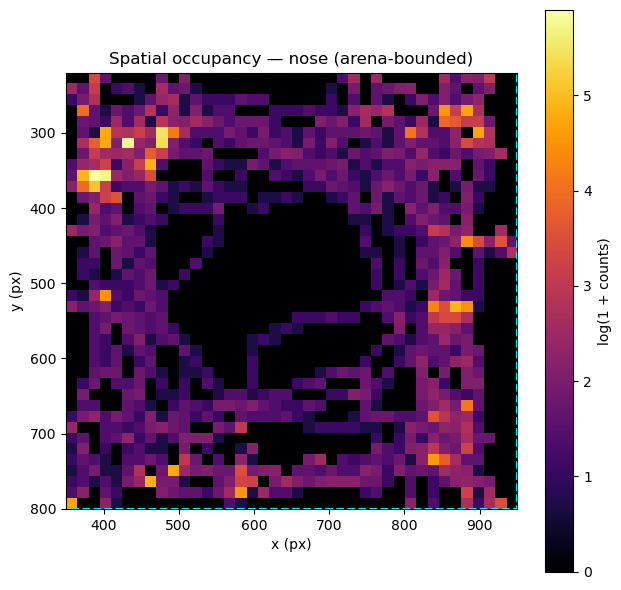

In [3]:
# === Spatial Occupancy with Fixed Arena Boundaries ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Arena boundaries (in pixels) ---
# TODO: adjust if needed after a quick visual check
X_MIN, X_MAX = 350, 950
Y_MIN, Y_MAX = 220, 800
ARENA_EXTENT = [X_MIN, X_MAX, Y_MIN, Y_MAX]

# --- Choose body part for occupancy map ---
# (Try "nose", "midback", or "tail_base")
PART = "nose"

# Extract coordinates
x = df[f"{PART}_x"].to_numpy(float)
y = df[f"{PART}_y"].to_numpy(float)

# Keep points that are valid AND inside arena bounds
valid = (~np.isnan(x)) & (~np.isnan(y))
inside = (x >= X_MIN) & (x <= X_MAX) & (y >= Y_MIN) & (y <= Y_MAX)
mask = valid & inside

xv, yv = x[mask], y[mask]

# Build 2D histogram within the arena only
bins = 40  # TODO: try 40 (coarser) or 100 (finer)
H, xedges, yedges = np.histogram2d(
    xv, yv, bins=bins,
    range=[[X_MIN, X_MAX], [Y_MIN, Y_MAX]]
)

# Plot occupancy heatmap
fig, ax = plt.subplots(figsize=(6.5, 6.0))
im = ax.imshow(
    np.log1p(H.T),            # log scale to reveal low counts
    origin="lower",
    extent=ARENA_EXTENT,
    aspect="equal",
    cmap="inferno",
    interpolation="nearest"
)

# Draw arena rectangle for reference
rect = Rectangle((X_MIN, Y_MIN), X_MAX - X_MIN, Y_MAX - Y_MIN,
                 fill=False, edgecolor="cyan", linewidth=1.5, linestyle="--")
ax.add_patch(rect)

ax.set_title(f"Spatial occupancy — {PART} (arena-bounded)")
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
plt.colorbar(im, ax=ax, label="log(1 + counts)")

# Optional: flip if your arena looks vertically inverted
ax.invert_yaxis()

plt.tight_layout()
plt.show()


You might have noticed that we made the heatmap showing `log(1 + counts)` instead of a time unit. 
**Why do you think is that?**

Each square (bin) in this heatmap counts **how many video frames** the mouse was seen there.  

When we make a heatmap like this:
```
H, _, _ = np.histogram2d(x, y, bins=bins)
plt.imshow(np.log1p(H.T))
```
each cell in H = number of frames where the mouse was seen inside that spatial bin.

- If a bin was visited 3 frames → H = 3
- If it was visited 3000 frames → H = 3000

Some areas might have **thousands** of frames (the mouse stayed there a lot).  
Others might have only a few frames.  

If we plot these raw counts directly, the few “hot” bins dominate the color scale,  
and the rest of the map looks almost black.  

Taking the logarithm: `np.log1p(H)  # same as log(1 + H)`

- compresses the scale:
- keeps hotspots visible, but also lets us see faintly visited areas, giving a more balanced picture of the whole exploration.
- This is a good option when you want to see patterns

### 🔢 How to express time instead of log-units
If we know the **frame rate (FPS)**, we can convert counts → **seconds**:

**📋 Instructions:**
- 🧩 Execute the next cell to see the result in s 
Now each color directly represents the number of seconds the mouse spent in that location.
This version is better when you want quantitative measures, not just patterns.

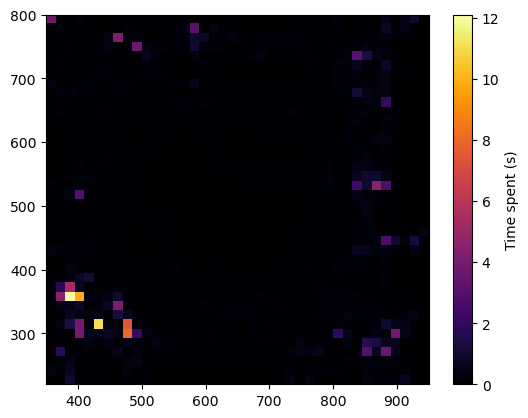

In [4]:
FPS = 30  # frames per second
time_spent = H / FPS
plt.imshow(time_spent.T, origin="lower", extent=ARENA_EXTENT, cmap="inferno")
plt.colorbar(label="Time spent (s)")

🧠 **Questions:**  
- If your recordings have different lengths (e.g. one is 2 min, another 5 min), the total number of frames, and therefore counts will differ. To compare fairly between sessions, what can you do? 
  you can normalize by total time or total frames:Normalization makes the map show where the animal prefers to be,
independent of how long the recording lasted.
- **🟠 When to use `log(1 + counts)` (for visibility):**  
- When the goal is **visual exploration** — to *see patterns clearly* rather than measure precisely.  
- It helps when there’s a **huge dynamic range** (some zones very occupied, others rarely visited).  
- Ideal for teaching, quick data checks, or presentations where we want to highlight structure.  
- Example: looking for *hotspots* or movement zones in exploratory sessions.

✅ *Think of it like adjusting the contrast of a photo — you see both shadows and highlights.*

---

**🔵 When to use `H / FPS` or normalized occupancy:**  
- When you want **quantitative or comparable values**, not just pretty colors.  
- Converting counts to **seconds** (`H / FPS`) makes the map physically meaningful — “how long” in each zone.  
- **Normalization** (e.g., `H / H.sum()`) is essential when comparing across:
  - different session lengths,  
  - different mice,  
  - or different conditions (arena vs bedding).  
- Example: comparing “time spent in center” between two animals.

✅ *This turns the heatmap into a measurable behavioral feature.*

---

**🟣 When to use both side-by-side:**  
- To link **interpretability** and **quantitative meaning**:
  - The `log(1 + counts)` version shows overall exploration patterns at a glance.  
  - The `H / FPS` (or normalized) version provides the scientific numbers behind it.  
- In reports or teaching notebooks, showing both helps students connect:
  > “Where the mouse goes most” ↔ “How much time it actually spends there.”

✅ *Together, they tell both the story (log map) and the statistics (time map).*

5. ⚡ Temporal dynamics — “When is the mouse active?”

Compute instantaneous speed from one bodypart (nose or mid-back).

Plot 6: Speed vs. time (line plot).

Highlight active vs. rest phases (color bands or threshold).

Optional animation: Color of the mouse marker changes with speed (slow = blue, fast = red).

Exercise:

Estimate total active time and discuss if activity seems periodic.

6. 🧭 Body orientation and coordination

Compute angle (nose → tail_base).

Plot 7: Angle vs. time (turning direction).

Plot 8: Animated skeleton: connect bodyparts (nose–tail, limbs).

Each frame shows stick figure of the mouse moving across the arena.

Exercise:

Observe if turning occurs mostly in certain zones.

7. 🔢 Quantitative metrics summary

Compute and display:

Total distance traveled

% active time

Mean & max speed

Time in center vs edges

Plot 9: Simple bar or pie chart of these summaries.

Exercise:

Which metric would change most if the mouse became habituated?

8. 🎥 Bonus: short animation exports

Create a short animation (10–20 s) showing:

The trajectory traced progressively.

A colorbar indicating time or speed.

(Optional) Stick-figure overlay connecting keypoints.

Encourage students to experiment with frame intervals or trail length.

🧠 Reflection:

“How does visualization help interpret behavior compared to raw numbers?”

9. 🔬 Discussion — Scientific interpretation

Summarize what can be inferred: exploration pattern, activity rhythm, possible habituation.

Compare with what would happen with bedding (noisy coordinates, less clear trajectories).

Open discussion prompts:

How would occlusions affect speed and occupancy estimates?

Would you still trust edge vs. center metrics in a cluttered cage?

Which visualizations remain valid across both contexts?